In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from sklearn.metrics import recall_score, precision_score
from models import save_model, generate_model_CNN, plot_performance
from generators import generator, decode, decode2

Using TensorFlow backend.


In [2]:
save_dir = 'plots'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)

X_load = np.load('../data/processed_data/m4015_session2/X.npy')
Y_load = np.load('../data/processed_data/m4015_session2/y.npy')

res = tf.one_hot(Y_load, depth=2)
with tf.Session() as sess:
    Y_load = (sess.run(res))

split_index = int(X_load.shape[0]*0.8)
    
X_train = X_load[:split_index]
Y_train = Y_load[:split_index]
X_val = X_load[split_index:]
Y_val = Y_load[split_index:]

In [3]:
batch_size = 1000
time_window = 50
n_dim = 1
class_weight = {0: 1., 1: 100.,}
predict_early = 0

input_shape = (time_window, n_dim)

In [4]:
train_generator = generator(X_train, Y_train, batch_size, time_window, predict_early=predict_early)
validate_generator = generator(X_val, Y_val, batch_size, time_window, predict_early=predict_early)

In [5]:
model = generate_model_CNN(input_shape)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 6)             48        
_________________________________________________________________
average_pooling1d_1 (Average (None, 25, 6)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 12)            516       
_________________________________________________________________
average_pooling1d_2 (Average (None, 12, 12)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 12)            1020      
_________________________________________________________________
average_pooling1d_3 (Average (None, 6, 12)             0         
__________

In [6]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=1000,
                              epochs=10, 
                              verbose=1,
                              validation_data=validate_generator,
                              validation_steps=1000,
                              class_weight=class_weight, )

save_model(model, name=predict_early)

Epoch 1/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.4977 - acc: 0.9584 - val_loss: 0.0748 - val_acc: 0.9789
Epoch 2/10
1000/1000 [==============================] - 107s 107ms/step - loss: 0.3643 - acc: 0.9532 - val_loss: 0.0525 - val_acc: 0.9809
Epoch 3/10
1000/1000 [==============================] - 112s 112ms/step - loss: 0.3288 - acc: 0.9569 - val_loss: 0.0891 - val_acc: 0.9743
Epoch 4/10
1000/1000 [==============================] - 121s 121ms/step - loss: 0.3525 - acc: 0.9572 - val_loss: 0.0635 - val_acc: 0.9778
Epoch 5/10
1000/1000 [==============================] - 118s 118ms/step - loss: 0.3097 - acc: 0.9584 - val_loss: 0.0571 - val_acc: 0.9806
Epoch 6/10
1000/1000 [==============================] - 106s 106ms/step - loss: 0.3210 - acc: 0.9585 - val_loss: 0.0767 - val_acc: 0.9747
Epoch 7/10
1000/1000 [==============================] - 118s 118ms/step - loss: 0.3131 - acc: 0.9580 - val_loss: 0.0361 - val_acc: 0.9873
Epoch 8/10
1000/1000 [==============

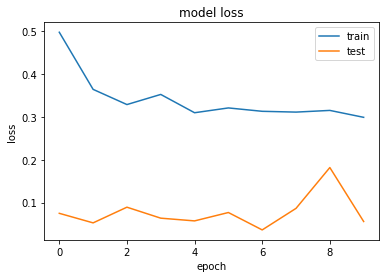

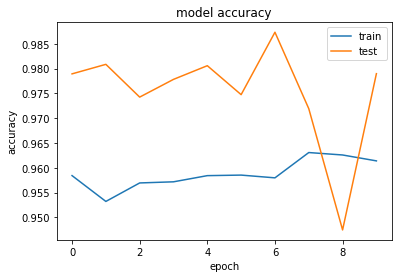

In [7]:
plot_performance(history)

In [8]:
validate_generator = generator(X_val, Y_val, batch_size*10, time_window)

X_trial, y_trial, = next(validate_generator)
res = model.predict(X_trial)

In [9]:
y_true = decode(y_trial)
y_pred = decode(res)

weights = np.zeros_like(y_true)
weights[y_true==0] = 1
weights[y_true==1] = 100


In [10]:
from sklearn.metrics import balanced_accuracy_score, recall_score, classification_report, confusion_matrix

print(balanced_accuracy_score(y_true, y_pred, adjusted=True))
print(recall_score(y_true, y_pred, average='weighted'))

target_names = ['no ripple', 'ripple',]
print(classification_report(y_true, y_pred, target_names=target_names))

0.0
0.9965
              precision    recall  f1-score   support

   no ripple       1.00      1.00      1.00      9965
      ripple       0.00      0.00      0.00        35

   micro avg       1.00      1.00      1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.99      1.00      0.99     10000



/Users/astasik/anaconda3/envs/machine/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
conv_matrix = confusion_matrix(y_true, y_pred)
print(conv_matrix)
conv_matrix = conv_matrix.astype('float') / conv_matrix.sum(axis=1)[:, np.newaxis]
print(conv_matrix)

[[9965    0]
 [  35    0]]
[[1. 0.]
 [1. 0.]]


In [12]:
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)